# Naive Bayes

Naive Bayes is a simple yet powerful probabilistic algorithm commonly used for classification tasks. It is based on Bayes' Theorem, which describes the probability of an event, based on prior knowledge of conditions that might be related to the event. The "naive" aspect of the algorithm comes from the assumption that all features are independent of each other, which simplifies the calculations but may not always hold true in real-world data.

Despite its simplicity, Naive Bayes is highly effective for certain types of classification problems, especially in cases where the dimensionality of the input is high, such as text classification and spam detection.

In this notebook, we will explore how to use Naive Bayes for classification problems using PySpark. Specifically, we will work with the classic Titanic dataset, which includes information about passengers and whether they survived or not. Our goal will be to build a Naive Bayes model that can predict the likelihood of survival based on features like age, gender, and passenger class. We will cover the following topics:

    1. Loading and preparing the data
    2. Training a Naive Bayes model using PySpark's MLlib library
    3. Evaluating the model's performance using various metrics
    4. Discussing the impact of the independence assumption and how it affects performance

By the end of this notebook, you should have a solid understanding of how Naive Bayes works and how to apply it to classification problems using PySpark.

### Importing necessary libraries and download dataset 

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import RFormula
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [2]:
! curl https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data --output iris.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  4551    0  4551    0     0   1873      0 --:--:--  0:00:02 --:--:--  1875
100  4551    0  4551    0     0   1873      0 --:--:--  0:00:02 --:--:--  1874


In [2]:
# create schema for easy human read 
schema_iris = 'sepal_length FLOAT, sepal_width FLOAT, petal_length FLOAT, petal_width FLOAT, class STRING'

# init SparkSession
spark = SparkSession.builder.appName('DecisionTreeClassifier').getOrCreate()
# read the csv using pyspark
iris = spark.read.csv('./iris.csv', schema=schema_iris, header=False)

# print few lines of the dataframe
iris.show(5)

+------------+-----------+------------+-----------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|      class|
+------------+-----------+------------+-----------+-----------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|
+------------+-----------+------------+-----------+-----------+
only showing top 5 rows



## Exploratory Data Analysis

### Summary statistics of the dataset

In this section, we will explore the iris datasets giving some statistic description like mean, std, etc.

In [3]:
iris.select('sepal_length', 'sepal_width', 'petal_length', 'petal_width').describe().show()

+-------+------------------+-------------------+------------------+------------------+
|summary|      sepal_length|        sepal_width|      petal_length|       petal_width|
+-------+------------------+-------------------+------------------+------------------+
|  count|               150|                150|               150|               150|
|   mean| 5.843333326975505| 3.0540000025431313|3.7586666552225747| 1.198666658103466|
| stddev|0.8280661128539085|0.43359431104332985|1.7644204144315179|0.7631607319020202|
|    min|               4.3|                2.0|               1.0|               0.1|
|    max|               7.9|                4.4|               6.9|               2.5|
+-------+------------------+-------------------+------------------+------------------+



In [4]:
iris.select('class').distinct().show()

+---------------+
|          class|
+---------------+
| Iris-virginica|
|    Iris-setosa|
|Iris-versicolor|
+---------------+



## Data Preparation

### Splitting the dataset into training and testing sets

In [5]:
train, test = iris.randomSplit([0.8, 0.2])

### Preprocessing the data (e.g., scaling, normalization, encoding)

Here we will use the RFormula to separate and treat the dataframe and the StandardScaler

In [22]:
formula = RFormula(formula='class ~ .', featuresCol='features', labelCol='label')
# only to see if everything is ok
temp = formula.fit(train).transform(train)
temp.show(5)

+------------+-----------+------------+-----------+-----------+--------------------+-----+
|sepal_length|sepal_width|petal_length|petal_width|      class|            features|label|
+------------+-----------+------------+-----------+-----------+--------------------+-----+
|         4.3|        3.0|         1.1|        0.1|Iris-setosa|[4.30000019073486...|  2.0|
|         4.4|        3.0|         1.3|        0.2|Iris-setosa|[4.40000009536743...|  2.0|
|         4.5|        2.3|         1.3|        0.3|Iris-setosa|[4.5,2.2999999523...|  2.0|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|[4.59999990463256...|  2.0|
|         4.6|        3.2|         1.4|        0.2|Iris-setosa|[4.59999990463256...|  2.0|
+------------+-----------+------------+-----------+-----------+--------------------+-----+
only showing top 5 rows



In [30]:
# one hot encoding
import pyspark.ml.feature as ft

encoder = ft.OneHotEncoder(inputCol='label', outputCol='labelVec')
# only to see if everything is ok
encoder.fit(temp).transform(temp).show(5, truncate=False)

+------------+-----------+------------+-----------+-----------+---------------------------------------------------------------------------+-----+---------+
|sepal_length|sepal_width|petal_length|petal_width|class      |features                                                                   |label|labelVec |
+------------+-----------+------------+-----------+-----------+---------------------------------------------------------------------------+-----+---------+
|4.3         |3.0        |1.1         |0.1        |Iris-setosa|[4.300000190734863,3.0,1.100000023841858,0.10000000149011612]              |2.0  |(2,[],[])|
|4.4         |3.0        |1.3         |0.2        |Iris-setosa|[4.400000095367432,3.0,1.2999999523162842,0.20000000298023224]             |2.0  |(2,[],[])|
|4.5         |2.3        |1.3         |0.3        |Iris-setosa|[4.5,2.299999952316284,1.2999999523162842,0.30000001192092896]             |2.0  |(2,[],[])|
|4.6         |3.1        |1.5         |0.2        |Iris-setosa|[

In [54]:
# IMPORTANT only fit the scaler using the training set
temp = formula.fit(train).transform(train)
scaler = MinMaxScaler(inputCol='features', outputCol='features_norm', min=0.1, max=1)
# only to see if everything is ok
temp = scaler.fit(temp).transform(temp).select('features', 'features_norm')
temp.show(10, truncate=False)

+----------------------------------------------------------------------------+---------------------------------------------------------------------------------+
|features                                                                    |features_norm                                                                    |
+----------------------------------------------------------------------------+---------------------------------------------------------------------------------+
|[4.300000190734863,3.0,1.100000023841858,0.10000000149011612]               |[0.1,0.47499998509883945,0.11525424067846007,0.1]                                |
|[4.400000095367432,3.0,1.2999999523162842,0.20000000298023224]              |[0.1249999768204153,0.47499998509883945,0.14576270385091258,0.13750000058207662] |
|[4.5,2.299999952316284,1.2999999523162842,0.30000001192092896]              |[0.14999995364083063,0.21249997764825912,0.14576270385091258,0.17500000395812093]|
|[4.599999904632568,3.099999904632

In [26]:
from pyspark.ml import  Transformer
class DropColumns(Transformer):
    def __init__(self, columns_to_drop=None):
        super(DropColumns, self).__init__()
        self.columns_to_drop = columns_to_drop if columns_to_drop else []

    def _transform(self, dataset):
        return dataset.drop(*self.columns_to_drop)

In [27]:
drop_columns = DropColumns(columns_to_drop=["label"])

## Model Training

### Building a simplest Naive Bayes model

In [55]:
nb = NaiveBayes(labelCol="label", featuresCol="features_norm")
pipeline = Pipeline(stages=[formula, scaler, nb])

### Training the model with the data

In [56]:
model = pipeline.fit(train)

### Evaluating the performance of the model on the test set 

In [57]:
prd = model.transform(test)
prd.show(5)

+------------+-----------+------------+-----------+---------------+--------------------+-----+--------------------+--------------------+--------------------+----------+
|sepal_length|sepal_width|petal_length|petal_width|          class|            features|label|       features_norm|       rawPrediction|         probability|prediction|
+------------+-----------+------------+-----------+---------------+--------------------+-----+--------------------+--------------------+--------------------+----------+
|         4.4|        2.9|         1.4|        0.2|    Iris-setosa|[4.40000009536743...|  2.0|[0.12499997682041...|[-2.3461380595793...|[0.32493910042469...|       2.0|
|         4.4|        3.2|         1.3|        0.2|    Iris-setosa|[4.40000009536743...|  2.0|[0.12499997682041...|[-2.5259209983273...|[0.30800492483095...|       2.0|
|         4.8|        3.0|         1.4|        0.1|    Iris-setosa|[4.80000019073486...|  2.0|[0.22500000331136...|[-2.5078111901886...|[0.31644383218899..

In [58]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator.evaluate(prd)

0.6296296296296297

In [72]:
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplit

dt_param_builder = (ParamGridBuilder()
             .addGrid(nb.smoothing, [0.2, 0.4, 0.6, 0.8])
             .addGrid(nb.modelType, ['multinomial', 'gaussian'])
             # 3 classses
             .addGrid(nb.thresholds, [[1/3, 1/3, 1/3], [0.1, 0.8, 0.1], [0.2, 0.6, 0.2]])
             .build())
pipeline = Pipeline(stages=[formula, scaler, nb])
tvs = TrainValidationSplit(estimator=pipeline, estimatorParamMaps=dt_param_builder, evaluator=evaluator, trainRatio=0.9)

In [73]:
model2 = tvs.fit(train)

In [74]:
prd2 = model2.transform(test)
prd2.show(5)

+------------+-----------+------------+-----------+---------------+--------------------+-----+--------------------+--------------------+--------------------+----------+
|sepal_length|sepal_width|petal_length|petal_width|          class|            features|label|       features_norm|       rawPrediction|         probability|prediction|
+------------+-----------+------------+-----------+---------------+--------------------+-----+--------------------+--------------------+--------------------+----------+
|         4.4|        2.9|         1.4|        0.2|    Iris-setosa|[4.40000009536743...|  2.0|[0.12499997682041...|[-2.3491686895011...|[0.32513340046125...|       2.0|
|         4.4|        3.2|         1.3|        0.2|    Iris-setosa|[4.40000009536743...|  2.0|[0.12499997682041...|[-2.5303882159523...|[0.30748110307116...|       2.0|
|         4.8|        3.0|         1.4|        0.1|    Iris-setosa|[4.80000019073486...|  2.0|[0.22500000331136...|[-2.5115213988417...|[0.31620324575742..

In [75]:
evaluator.evaluate(prd2)

0.6296296296296297

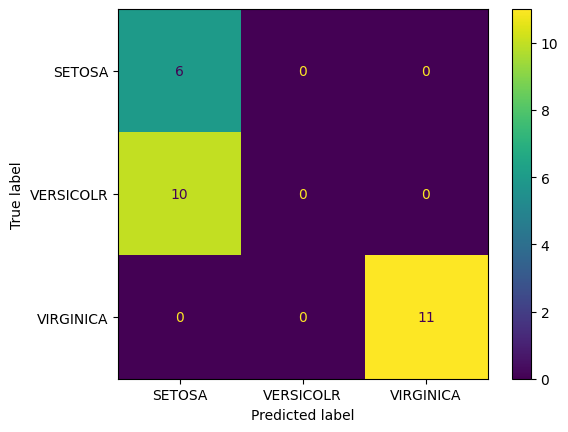

In [76]:
from sklearn import metrics
import matplotlib.pyplot as plt

df_prd = prd.select('label', 'prediction').toPandas()
cm = metrics.confusion_matrix(df_prd['label'], df_prd['prediction'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['SETOSA','VERSICOLR','VIRGINICA'])
cm_display.plot()
plt.show()